In [4]:
import os, sys
import dotenv
dotenv.load_dotenv('../.env')

import numpy as np
import torch
import pandas as pd
from scipy.stats import kendalltau, pearsonr, spearmanr
import pandas as pd
from torchvision import transforms

import wandb
from collections import defaultdict
import json
from pathlib import Path
from tqdm import tqdm
from copy import deepcopy
import warnings
import matplotlib.pyplot as plt
import time

sys.path.append('../')
from common import OnnxModel, BOLT_DIR
from metrics.metrics import calculate_open_loop_metrics, calculate_closed_loop_metrics
from dataloading.nvidia import NvidiaElvaDataset, NvidiaDataset

WANDB_ENTITY = os.getenv('WANDB_ENTITY')
WANDB_PROJECT = os.getenv('WANDB_PROJECT')

In [3]:
df = pd.read_csv('results/ebm-experiments-final-results.csv')
# convert str to tuple
df['drive'] = df['drive'].apply(lambda x: tuple(x[1:-1].replace('\'', '').split(',')))
df['drive'] = df['drive'].apply(lambda x: [i.strip() for i in x if i != ''])
df

,training_run,model_name,real_interventions,drive,elva_mae,elva_whiteness,elva_expert_whiteness,val_mae,model_type,traj_mae,traj_rmse,traj_max,traj_failure_rate,distance,distance_per_intervention,whiteness,cmd_whiteness,expert_whiteness
0,3ftnqxcb,ebm-512-s1,4,[ebm-paper-ebm-512-s1-forward_2022-09-21-10-51...,7.487386,191.060638,17.679368,8.607146,pilotnet-ebm,0.502133,0.617828,1.716365,10.592712,8479.229138,2119.807285,35.247937,176.928088,17.655094
1,3ftnqxcb,ebm-512-s1,1,[ebm-paper-ebm-512-s1-forward_2022-09-22-11-02...,7.487386,191.060638,17.679368,8.607146,pilotnet-ebm,0.449918,0.564381,1.713574,8.773010,8535.219556,8535.219556,32.340420,96.937671,17.655094
2,3ftnqxcb,ebm-512-s1,2,[ebm-paper-ebm-512-s1-forward_2022-09-23-11-18...,7.487386,191.060638,17.679368,8.607146,pilotnet-ebm,0.482874,0.592681,1.718401,9.072609,8519.657455,4259.828728,28.570325,223.588494,17.655094
3,3jk7cnqa,ebm-normal-1-s1,5,[e2e-ebm-normal-1-s1-day1-forward_2022-09-20-1...,6.974703,152.191879,17.679368,8.437540,pilotnet-ebm,0.412358,0.524989,1.721364,5.836352,8473.096473,1694.619295,49.922412,119.390706,17.655094
4,3jk7cnqa,ebm-normal-1-s1,2,[ebm-paper-ebm-normal-1-s1-forward_2022-09-22-...,6.974703,152.191879,17.679368,8.437540,pilotnet-ebm,0.407956,0.512668,1.708277,5.597071,8473.696547,4236.848274,38.956632,137.220901,17.655094
5,3jk7cnqa,ebm-normal-1-s1,3,[ebm-paper-ebm-normal-1-s1-forward_2022-09-23-...,6.974703,152.191879,17.679368,8.437540,pilotnet-ebm,0.447816,0.552821,1.596786,7.919993,8520.976775,2840.325592,34.206305,77.275104,17.655094
6,2jvl4yhn,ebm-spatial-0-s2,5,[e2e-ebm-spatial-0-s2-day1-forward_2022-09-20-...,6.909929,125.816818,17.679368,8.738031,pilotnet-ebm,0.436406,0.548320,1.640132,6.909590,8444.219201,1688.843840,27.796907,56.328374,17.655094
7,2jvl4yhn,ebm-spatial-0-s2,5,[ebm-paper-ebm-spatial-0-s2-forward_2022-09-21...,6.909929,125.816818,17.679368,8.738031,pilotnet-ebm,0.442618,0.559457,1.509779,8.546063,8442.245854,1688.449171,46.829478,57.148334,17.655094
8,2jvl4yhn,ebm-spatial-0-s2,4,[ebm-paper-ebm-spatial-0-s2-forward_2022-09-23...,6.909929,125.816818,17.679368,8.738031,pilotnet-ebm,0.464354,0.583141,1.689208,8.905860,8466.304693,2116.576173,33.723343,56.861922,17.655094
9,bxd5wtqk,mae-s2,2,"[e2e-mae-s2-day1-forward_2022-09-20-11-25-14, ...",7.196932,54.846653,17.679368,7.828012,pilotnet,0.400974,0.504417,1.597662,5.848605,8516.510890,4258.255445,26.690530,37.836591,17.655094


In [5]:
def smoothed_steering_angle(curr_eff_steering_angle, new_cmd_steering_angle, alpha=0.1):
    return alpha * new_cmd_steering_angle + (1 - alpha) * curr_eff_steering_angle

In [10]:
import math
from torch.utils.data import DataLoader

root_path = Path(BOLT_DIR) / 'end-to-end/drives-ebm-paper'

class DynamicsDataset(torch.utils.data.IterableDataset):
    def __init__(self, nvidia_datasets, seq_len=2*30):
        self.datasets = nvidia_datasets
        self.seq_len = seq_len

        for i, ds in enumerate(self.datasets):
            ds.frames = ds.frames[ds.frames['autonomous'] == True]
            ds.frames = ds.frames.loc[:, ['steering_angle', 'cmd_steering_angle']]
            ds.frames['cmd_steering_angle'] = ds.frames['cmd_steering_angle'] * 14.7

            # we want to predict a_eff[t] using a_eff[0:t-1] and a_cmd[1:t],
            # where len(a_eff[0:t-1]) == len(a_cmd[1:t])
            ds.frames['cmd_steering_angle'] = ds.frames['cmd_steering_angle'].shift(-1) 

            # don't drop last row, because we can still use it as a_eff[t]
            # ds.frames.dropna(inplace=True)
    
    def __len__(self):
        return math.ceil(sum([len(ds.frames) for ds in self.datasets]) / self.seq_len)
    
    def __iter__(self):
        for ds in self.datasets:
            for i in range(0, len(ds.frames), self.seq_len):
                frames = ds.frames[i:i+self.seq_len]
                cmd = frames['cmd_steering_angle'].values
                eff = frames['steering_angle'].values

                if len(cmd) < self.seq_len:
                    continue

                yield cmd, eff

def make_dataset(experiments_df):
    experiments_df['run_id'] = experiments_df.index
    val_runs_df = experiments_df.groupby('model_name').last().reset_index()
    train_runs_df = experiments_df[~experiments_df['run_id'].isin(val_runs_df['run_id'])]

    train_drives = sum(train_runs_df['drive'].values, [])
    val_drives = sum(val_runs_df['drive'].values, [])

    train_nvidia_ds_list = [NvidiaDataset([root_path / drive]) for drive in train_drives]
    val_nvidia_ds_list = [NvidiaDataset([root_path / drive]) for drive in val_drives]
    train_ds = DynamicsDataset(train_nvidia_ds_list)
    val_ds = DynamicsDataset(val_nvidia_ds_list)

    return train_ds, val_ds    

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import torch.nn.functional as F

class DynamicsGRU(torch.nn.Module):
    def __init__(self, hidden_size, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = torch.nn.GRU(2, hidden_size, num_layers, batch_first=False)
        self.fc_out = torch.nn.Linear(hidden_size, 1)
    
    def forward(self, x, y, h0=None, return_hidden=False, teacher_forcing=True):
        # reorder x from (batch_size, seq_len) to (seq_len, batch_size)
        x = x.permute(1, 0)
        y = y.permute(1, 0)

        # add feature dimension
        x = x.unsqueeze(2) 
        y = y.unsqueeze(2)

        seq_len, batch_size, _ = x.shape

        if h0 is None:
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

        if teacher_forcing:
            x_y = torch.cat([x, y], dim=2) # (seq_len, batch_size, 2)
            out, h_out = self.gru(x_y, h0) # outs: (seq_len, batch_size, hidden_size)
            out = self.fc_out(out.reshape(-1, self.hidden_size))
            out = out.reshape(seq_len, batch_size).permute(1, 0)

        elif not teacher_forcing:
            # this one will have an explicit loop
            # and will be slower
            # but it should learn to recover from its mistakes
            preds = torch.zeros(seq_len+1, batch_size, 1).to(device)
            preds[0] = x[0] # initialize with first command
            hidden = h0
            for i in range(seq_len):
                x_y = torch.cat([x[i:i+1, :], preds[i:i+1, :]], dim=2)
                # print('x_y.shape', x_y.shape)
                out, hidden = self.gru(x_y, hidden)
                # torch.testing.assert_allclose(out, hidden)
                preds[i+1] = self.fc_out(out)
            out = preds[1:].squeeze(2).permute(1, 0)
            
        if return_hidden:
            return out, h_out
        return out

In [11]:
train_ds, val_ds = make_dataset(df)

[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/ebm-paper-ebm-512-s1-forward_2022-09-21-10-51-39: length=17873, filtered=0
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/ebm-paper-ebm-512-s1-backward_2022-09-21-11-02-14: length=18309, filtered=0
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/ebm-paper-ebm-512-s1-forward_2022-09-22-11-02-58: length=17899, filtered=0
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/ebm-paper-ebm-512-s1-backward_2022-09-22-11-13-52: length=18671, filtered=0
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/e2e-ebm-normal-1-s1-day1-forward_2022-09-20-13-37-56: length=18183, filtered=0
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/e2e-ebm-normal-1-s1-day1-backward_2022-09-20-13-48-42: length=18696, filt

In [12]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = torch.nn.MSELoss()
    
    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

> Epoch 1


loss: 0.0173 | val_loss: 0.0000: 100%|██████████| 55/55 [00:04<00:00, 11.37it/s]
27it [00:00, 28.75it/s]


> Epoch 2


loss: 0.0157 | val_loss: 0.0278: 100%|██████████| 55/55 [00:04<00:00, 11.05it/s]
27it [00:00, 33.65it/s]


> Epoch 3


loss: 0.0147 | val_loss: 0.0253: 100%|██████████| 55/55 [00:04<00:00, 11.12it/s]
27it [00:00, 29.49it/s]


> Epoch 4


loss: 0.0141 | val_loss: 0.0231: 100%|██████████| 55/55 [00:05<00:00, 10.76it/s]
27it [00:00, 31.57it/s]


> Epoch 5


loss: 0.0105 | val_loss: 0.0177: 100%|██████████| 55/55 [00:04<00:00, 11.43it/s]
27it [00:00, 30.08it/s]


> Epoch 6


loss: 0.0097 | val_loss: 0.0147: 100%|██████████| 55/55 [00:05<00:00, 10.95it/s]
27it [00:00, 29.98it/s]


> Epoch 7


loss: 0.0093 | val_loss: 0.0135: 100%|██████████| 55/55 [00:05<00:00, 10.67it/s]
27it [00:00, 31.02it/s]


> Epoch 8


loss: 0.0090 | val_loss: 0.0130: 100%|██████████| 55/55 [00:05<00:00, 10.75it/s]
27it [00:00, 29.05it/s]


> Epoch 9


loss: 0.0088 | val_loss: 0.0126: 100%|██████████| 55/55 [00:04<00:00, 11.53it/s]
27it [00:00, 30.39it/s]


> Epoch 10


loss: 0.0086 | val_loss: 0.0123: 100%|██████████| 55/55 [00:04<00:00, 11.20it/s]
27it [00:00, 32.03it/s]


> Epoch 11


loss: 0.0085 | val_loss: 0.0121: 100%|██████████| 55/55 [00:04<00:00, 11.23it/s]
27it [00:00, 32.60it/s]


> Epoch 12


loss: 0.0083 | val_loss: 0.0119: 100%|██████████| 55/55 [00:04<00:00, 11.52it/s]
27it [00:00, 31.04it/s]


> Epoch 13


loss: 0.0082 | val_loss: 0.0118: 100%|██████████| 55/55 [00:05<00:00, 10.83it/s]
27it [00:00, 30.76it/s]


> Epoch 14


loss: 0.0081 | val_loss: 0.0116: 100%|██████████| 55/55 [00:04<00:00, 11.53it/s]
27it [00:00, 30.94it/s]


> Epoch 15


loss: 0.0080 | val_loss: 0.0115: 100%|██████████| 55/55 [00:04<00:00, 11.48it/s]
27it [00:00, 30.30it/s]


> Epoch 16


loss: 0.0079 | val_loss: 0.0113: 100%|██████████| 55/55 [00:04<00:00, 11.30it/s]
27it [00:00, 30.86it/s]


> Epoch 17


loss: 0.0077 | val_loss: 0.0112: 100%|██████████| 55/55 [00:04<00:00, 11.46it/s]
27it [00:00, 30.13it/s]


> Epoch 18


loss: 0.0076 | val_loss: 0.0110: 100%|██████████| 55/55 [00:04<00:00, 11.47it/s]
27it [00:00, 31.54it/s]


> Epoch 19


loss: 0.0075 | val_loss: 0.0109: 100%|██████████| 55/55 [00:05<00:00, 10.96it/s]
27it [00:00, 32.99it/s]


> Epoch 20


loss: 0.0073 | val_loss: 0.0107: 100%|██████████| 55/55 [00:04<00:00, 12.02it/s]
27it [00:00, 31.16it/s]


> Epoch 21


loss: 0.0072 | val_loss: 0.0105: 100%|██████████| 55/55 [00:04<00:00, 11.60it/s]
27it [00:00, 30.57it/s]


> Epoch 22


loss: 0.0071 | val_loss: 0.0103: 100%|██████████| 55/55 [00:04<00:00, 11.24it/s]
27it [00:00, 30.58it/s]


> Epoch 23


loss: 0.0070 | val_loss: 0.0102: 100%|██████████| 55/55 [00:04<00:00, 11.59it/s]
27it [00:00, 30.26it/s]


> Epoch 24


loss: 0.0070 | val_loss: 0.0100: 100%|██████████| 55/55 [00:04<00:00, 11.54it/s]
27it [00:00, 30.95it/s]


> Epoch 25


loss: 0.0069 | val_loss: 0.0099: 100%|██████████| 55/55 [00:04<00:00, 11.65it/s]
27it [00:00, 31.33it/s]


> Epoch 26


loss: 0.0069 | val_loss: 0.0098: 100%|██████████| 55/55 [00:04<00:00, 11.07it/s]
27it [00:00, 29.85it/s]


> Epoch 27


loss: 0.0069 | val_loss: 0.0098: 100%|██████████| 55/55 [00:04<00:00, 11.39it/s]
27it [00:00, 31.11it/s]


> Epoch 28


loss: 0.0069 | val_loss: 0.0097: 100%|██████████| 55/55 [00:05<00:00, 10.89it/s]
27it [00:00, 31.06it/s]


> Epoch 29


loss: 0.0069 | val_loss: 0.0096: 100%|██████████| 55/55 [00:04<00:00, 11.09it/s]
27it [00:00, 29.84it/s]


> Epoch 30


loss: 0.0069 | val_loss: 0.0096: 100%|██████████| 55/55 [00:05<00:00, 11.00it/s]
27it [00:00, 32.20it/s]


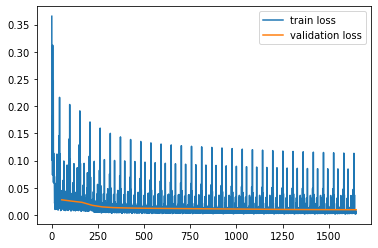

In [49]:
batch_size = 128
num_workers = 0
gru_hidden_size = 128
gru_layers = 1

dataloader = DataLoader(train_ds, 
            pin_memory=True,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=False,
            drop_last=True,
)
val_dataloader = DataLoader(val_ds,
            pin_memory=True,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=False,
            drop_last=True,
)

model = DynamicsGRU(gru_hidden_size, gru_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

iter_num = 0

def train(model, dataloader, val_dataloader, optimizer, criterion, device, num_epochs=10):
    loss_history = {}
    val_loss_history = {}
    loss = 0
    val_loss = 0
    for epoch in range(num_epochs):
        print(f'> Epoch {epoch+1}')
        progress = tqdm(enumerate(dataloader), total=len(dataloader))
        for i, (cmd, eff) in progress:
            cmd = cmd.to(device, dtype=torch.float32)
            eff = eff.to(device, dtype=torch.float32)

            model.train()
            outputs = model(cmd[:, :-1], eff[:, :-1], teacher_forcing=False) # -> a_eff[1:t]

            # print('outputs:', outputs.shape)
            # print('eff:', eff.shape)
            loss = criterion(outputs, eff[:, 1:])

            # backprop and update the parameters
            model.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
            optimizer.step()

            loss_history[epoch*len(dataloader) + i] = loss.detach().cpu().item()

            description = f'loss: {loss.detach().cpu().item():.4f} | val_loss: {val_loss:.4f}'
            progress.set_description(description)
            progress.update(1)

        val_loss = validation_loss(model, val_dataloader, criterion, device)
        val_loss_history[epoch*len(dataloader) + i] = val_loss
        description = f'loss: {loss.detach().cpu().item():.4f} | val_loss: {val_loss:.4f}'
        progress.set_description(description)

    history = {
        'loss': loss_history,
        'val_loss': val_loss_history,
    }
    return model, history

def validation_loss(model, val_dataloader, criterion, device):
    model.eval()
    val_loss_history = []
    with torch.no_grad():
        for i, (cmd, eff) in tqdm(enumerate(val_dataloader)):
            cmd = cmd.to(device, dtype=torch.float32)
            eff = eff.to(device, dtype=torch.float32)

            outputs = model(cmd[:, :-1], eff[:, :-1], teacher_forcing=False) # -> a_eff[1:t]
            loss = criterion(outputs, eff[:, 1:])
            val_loss_history.append(loss.detach().cpu().item())

    return np.mean(val_loss_history)

model, history = train(model, dataloader, val_dataloader, optimizer, criterion, device, num_epochs=30)

plt.plot(history['loss'].values(), label='train loss')
plt.plot(history['val_loss'].keys(), history['val_loss'].values(), label='validation loss')

plt.legend()
plt.show()

In [14]:
def infer(model, cmd_values, initial_eff_val=0.0):
    model.eval()
    outputs = [initial_eff_val]
    with torch.no_grad():
        hidden = None
        for i in range(len(cmd_values)):
            cmd = cmd_values[i]
            eff = outputs[i]
            if i == len(cmd_values)-1: break

            gru_inputs_cmd = torch.tensor([cmd]).reshape(1, 1).to(device, dtype=torch.float32)
            gru_inputs_eff = torch.tensor([eff]).reshape(1, 1).to(device, dtype=torch.float32)
            out, hidden = model(gru_inputs_cmd, gru_inputs_eff, h0=hidden, return_hidden=True)
            outputs.append(out.detach().cpu().item())

    return outputs

def infer_baseline(cmd_values, initial_eff_val=0.0, alpha: int = 0.075):
    outputs = [initial_eff_val]
    for i in range(len(cmd_values)):
        new_cmd = cmd_values[i]
        last_eff = outputs[i]

        last_eff = smoothed_steering_angle(last_eff, new_cmd, alpha=alpha)

        outputs.append(last_eff)
    return outputs


In [15]:
import torch.nn.functional as F
from collections import defaultdict

def evaluate(model, val_dataloader, device):
    model.eval()
    metrics = defaultdict(int)
    with torch.no_grad():
        for i, (cmd, eff) in tqdm(enumerate(val_dataloader)):
            cmd = cmd.to(device, dtype=torch.float32)
            eff = eff.to(device, dtype=torch.float32)

            outputs = model(cmd[:, :-1], eff[:, :-1], teacher_forcing=False) # -> a_eff[1:t]
            mse = F.mse_loss(outputs, eff[:, 1:])
            rmse = torch.sqrt(mse)
            mae = F.l1_loss(outputs, eff[:, 1:])
            bias = torch.mean(outputs - eff[:, 1:])

            metrics['mse'] += mse.detach().cpu().item()
            metrics['rmse'] += rmse.detach().cpu().item()
            metrics['mae'] += mae.detach().cpu().item()
            metrics['bias'] += bias.detach().cpu().item()

    for k in metrics.keys():
        metrics[k] /= len(val_dataloader)
        metrics[k] = np.degrees(metrics[k])

    return metrics

In [51]:
trues = []
preds_gru = []
preds_baseline = []

for ds in val_ds.datasets:
    frames = ds.frames.loc[:, ['steering_angle', 'cmd_steering_angle']]
    true = frames['steering_angle'].values
    cmd = frames['cmd_steering_angle'].values

    pred_baseline = infer_baseline(cmd[1:], true[0])
    trues.extend(true[1:])
    preds_baseline.extend(pred_baseline[:-1])

    assert len(trues) == len(preds_baseline)

trues = np.degrees(trues)
preds_baseline = np.degrees(preds_baseline)

metrics_model_v1 = evaluate(model_v1, val_dataloader, device)
metrics_model_v2 = evaluate(model, val_dataloader, device)

# print('RMSE model:', metrics_rmse_model)
print('model v1:', metrics_model_v1)
print('model v2:', metrics_model_v2)

mse_baseline = np.mean((trues - preds_baseline)**2)
print(f'smoothing baseline: {mse_baseline:.3f}')

27it [00:00, 31.19it/s]
27it [00:00, 34.30it/s]


model v1: defaultdict(<class 'int'>, {'mse': 0.6834244885458519, 'rmse': 5.326402764117986, 'mae': 2.5138058968888783, 'bias': 0.37205360149207034})
model v2: defaultdict(<class 'int'>, {'mse': 0.5283897781782281, 'rmse': 4.8446347535498395, 'mae': 2.3531688655943173, 'bias': 0.26629109587088107})
smoothing baseline: 30.775


In [50]:
model_v1 = DynamicsGRU(128, 1)
model_v1.load_state_dict(torch.load('dynamics_model_mae_val_loss_0.408_bias_0.42.pt'))
model_v1 = model_v1.to(device)

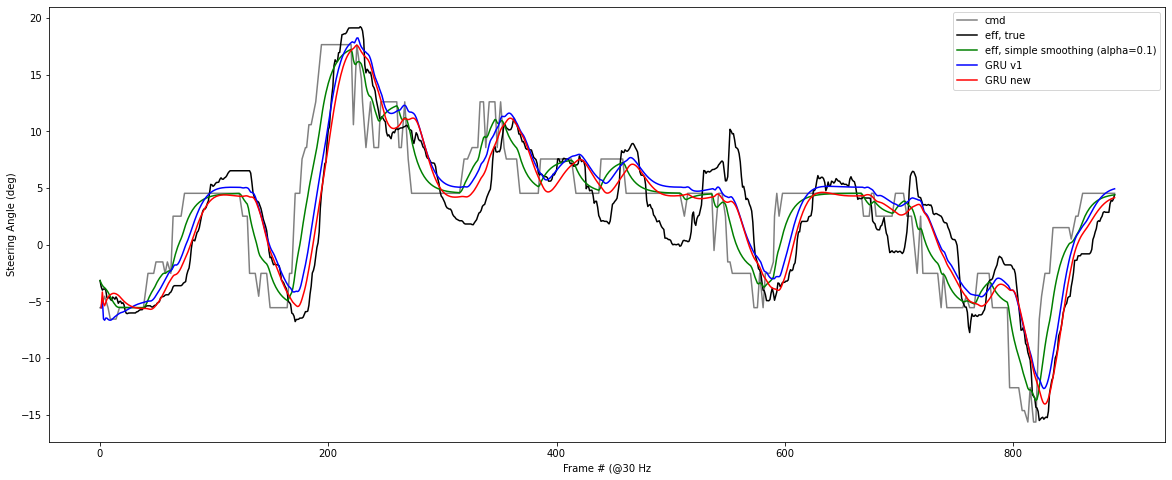

In [53]:
ds = val_ds.datasets[0]
alpha = 0.1

stuff = ds.frames.loc[:, ['steering_angle', 'cmd_steering_angle']].iloc[210:1100]

plt.figure(figsize=(20,8))
plt.xlabel('Frame # (@30 Hz')
plt.ylabel('Steering Angle (deg)')

eff_steering = stuff['steering_angle'].values
cmd_steering = stuff['cmd_steering_angle'].values
simple_preds = infer_baseline(cmd_steering[1:], eff_steering[0], alpha=alpha)
gru_preds_v1 = infer(model_v1, cmd_steering[1:], cmd_steering[0])
gru_preds = infer(model, cmd_steering[1:], cmd_steering[0])

zoom_start, zoom_end = [0, 1000]

plt.plot(np.arange(len(stuff))[zoom_start:zoom_end], np.degrees(cmd_steering)[zoom_start:zoom_end], label='cmd', color='grey')
plt.plot(np.arange(len(stuff))[zoom_start:zoom_end], np.degrees(eff_steering)[zoom_start:zoom_end], label='eff, true', color='black')
plt.plot(np.arange(len(stuff))[zoom_start:zoom_end], np.degrees(simple_preds)[zoom_start:zoom_end], label=f'eff, simple smoothing (alpha={alpha})', color='green')
plt.plot(np.arange(1, len(stuff))[zoom_start:zoom_end], np.degrees(gru_preds_v1)[zoom_start:zoom_end], label=f'GRU v1', color='blue')
plt.plot(np.arange(1, len(stuff))[zoom_start:zoom_end], np.degrees(gru_preds)[zoom_start:zoom_end], label=f'GRU new', color='red')

plt.legend()

In [54]:
torch.save(model.state_dict(), 'dynamics_model_v2.pt')

In [274]:
model = DynamicsGRU(128, 1)
model.load_state_dict(torch.load('dynamics_model_v2.pt'))
model = model.to(device)

In [55]:
import onnx

cmd, eff = iter(val_dataloader).next()
cmd = cmd[0:1, 0:1].to(device, dtype=torch.float32)
eff = eff[0:1, 0:1].to(device, dtype=torch.float32)
hidden = torch.zeros(1, 1, 128).to(device, dtype=torch.float32)

print(cmd.shape, eff.shape, hidden.shape)

sample_inputs = [cmd, eff, hidden, True, True, {}]

torch.onnx.export(model,
                  sample_inputs,
                  'dynamics_model_v2.onnx',
                  input_names=['cmd', 'eff'],
                  output_names=['eff_pred', 'hidden_state'],
                  opset_version=9,
                  do_constant_folding=False,
                )
onnx.checker.check_model('dynamics_model_v2.onnx')


torch.Size([1, 1]) torch.Size([1, 1]) torch.Size([1, 1, 128])


/tmp/ipykernel_27088/744702219.py:26: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if teacher_forcing:
/tmp/ipykernel_27088/744702219.py:47: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if return_hidden:
/home/nikita/miniconda3/envs/e2e/lib/python3.9/site-packages/torch/onnx/symbolic_opset9.py:2188: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with GRU can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial st

In [56]:
import onnxruntime as ort

ort_session = ort.InferenceSession('dynamics_model_v2.onnx', providers=['CUDAExecutionProvider'])

ds = val_ds.datasets[0]
stuff = ds.frames.loc[:, ['steering_angle', 'cmd_steering_angle']].iloc[1500:2000]

eff_steering = stuff['steering_angle'].values.astype(np.float32)
cmd_steering = stuff['cmd_steering_angle'].values.astype(np.float32)
hidden = np.zeros((1, 1, 128)).astype(np.float32)

preds = [cmd_steering[0]]

for i in range(cmd_steering.shape[0]):
    ort_inputs = {
        ort_session.get_inputs()[0].name: np.array(cmd_steering[i:i+1]).reshape(1,1),
        ort_session.get_inputs()[1].name: np.array(preds[i]).astype(np.float32).reshape(1, -1),
        ort_session.get_inputs()[2].name: hidden,
    }

    ort_outs = ort_session.run(None, ort_inputs)
    outs, hidden = ort_outs

    preds.append(outs.astype(np.float32).item())

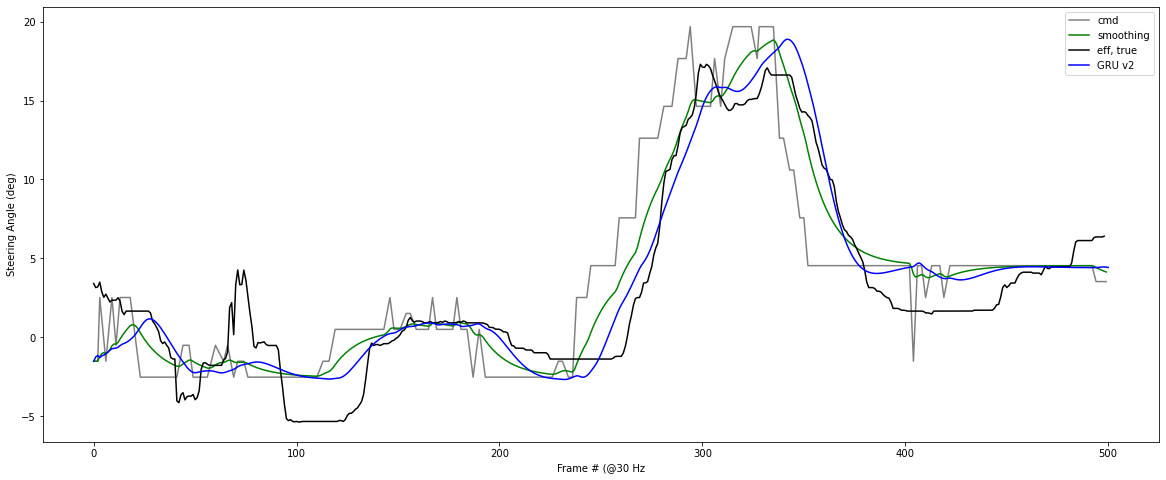

In [57]:
plt.figure(figsize=(20,8))
plt.xlabel('Frame # (@30 Hz')
plt.ylabel('Steering Angle (deg)')
plt.plot(np.arange(len(cmd_steering)), np.degrees(cmd_steering), label='cmd', color='grey')
plt.plot(np.arange(len(cmd_steering)), np.degrees(infer_baseline(cmd_steering[1:], cmd_steering[0])), label='smoothing', color='green')
plt.plot(np.arange(len(eff_steering[1:])), np.degrees(eff_steering[1:]), label='eff, true', color='black')
plt.plot(np.arange(len(preds)), np.degrees(preds), label='GRU v2', color='blue')
plt.legend()



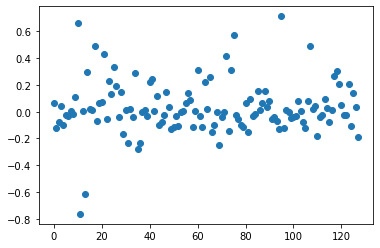

In [338]:
plt.scatter(np.arange(len(learned_initial_hidden_state.squeeze())), learned_initial_hidden_state.squeeze())